<a href="https://colab.research.google.com/github/rpradata-ud/DSPS_RPradata/blob/main/labs/RPradata_DSPS2023_autoencoders_8dec23_students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from copy import deepcopy

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from scipy.signal import convolve2d

from tensorflow import keras
from keras.datasets import mnist
from keras import layers

!pip install icecream
from icecream import ic

rng = np.random.RandomState(1415)

^Willow loves ice cream package

NN usage benfit for GPU compared to CPU

# Load MNIST data

In [ ]:
# Load the data and split it between train and test sets
(Xtrn, Ytrn), (Xtst, Ytst) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


^about mnist...

# Visualize dataset

In [ ]:
Xtrn.shape, Xtst.shape, Ytrn.shape, Ytst.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [ ]:
np.unique(Ytrn)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

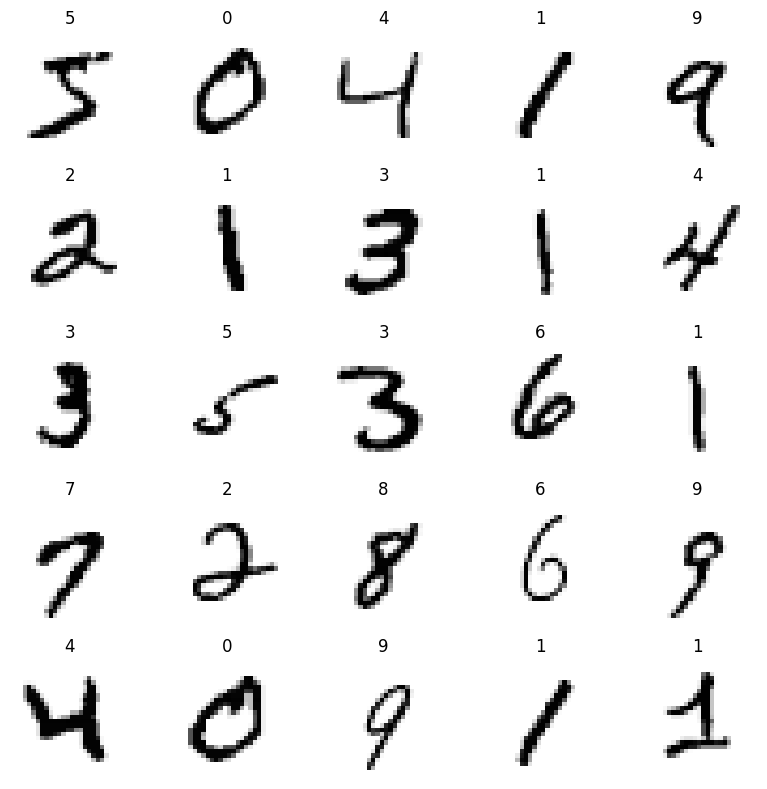

In [ ]:
#normalize dataset
def plot_images(images, labels, nrows=5, ncols=5, vmin=0, vmax = 255):
  fig, axes = plt.subplots(nrows, ncols, sharex = True, sharey=True, figsize = (8,8))

  for i in range(nrows * ncols):
    ax = axes.flatten()[i]
    image = images[i]
    label = labels[i]

    ax.set_title(label)
    ax.imshow(image, vmin=vmin, vmax=vmax, cmap = "Greys")
    ax.set_aspect("equal")
    ax.axis('off')

  fig.tight_layout()
  fig.show()

plot_images(Xtrn , Ytrn)

# Normalize the images

In [ ]:
def normalize_255(array):
  normed_array = array/255
  return normed_array

XtrnN = normalize_255(Xtrn)
XtstN = normalize_255(Xtst)

XtrnN.min(), XtrnN.max()

(0.0, 1.0)

# Reshape the arrays for Keras

In [ ]:
XtrnN.shape

(60000, 28, 28)

In [ ]:
def reshape_for_keras(array):
  reshaped_array = array[..., None]
  return reshaped_array

XtrnNR = reshape_for_keras(XtrnN)
XtstNR = reshape_for_keras(XtstN)

XtrnNR.shape

(60000, 28, 28, 1)

# One-hot encode the image labels

In [ ]:
YtrnOH = keras.utils.to_categorical(Ytrn, 10)

YtrnOH.shape

(60000, 10)

# But wait we don't need the image labels...

### The training set will be the images at half resolution, and the model will try to up-sample the images to the original resolution... `Xtrn` should be the same 60,000 images at half resolution, but `Ytrn` should be those same images at the original resolution. We will do the same operations for the testing set.

# Construct dataset for superresolution, not image classification

In [ ]:
def build_superresolution_dataset_from_mnist(X):
  Xnew = deepcopy(X)[:, ::2, ::2, :]
  Ynew = deepcopy(X)

  return Xnew, Ynew

XtrnSR, YtrnSR = build_superresolution_dataset_from_mnist(XtrnNR)
XtstSR, YtstSR = build_superresolution_dataset_from_mnist(XtstNR)

XtrnSR.shape, YtrnSR.shape, XtstSR.shape, YtstSR.shape

((60000, 14, 14, 1),
 (60000, 28, 28, 1),
 (10000, 14, 14, 1),
 (10000, 28, 28, 1))

# Visualize the new dataset

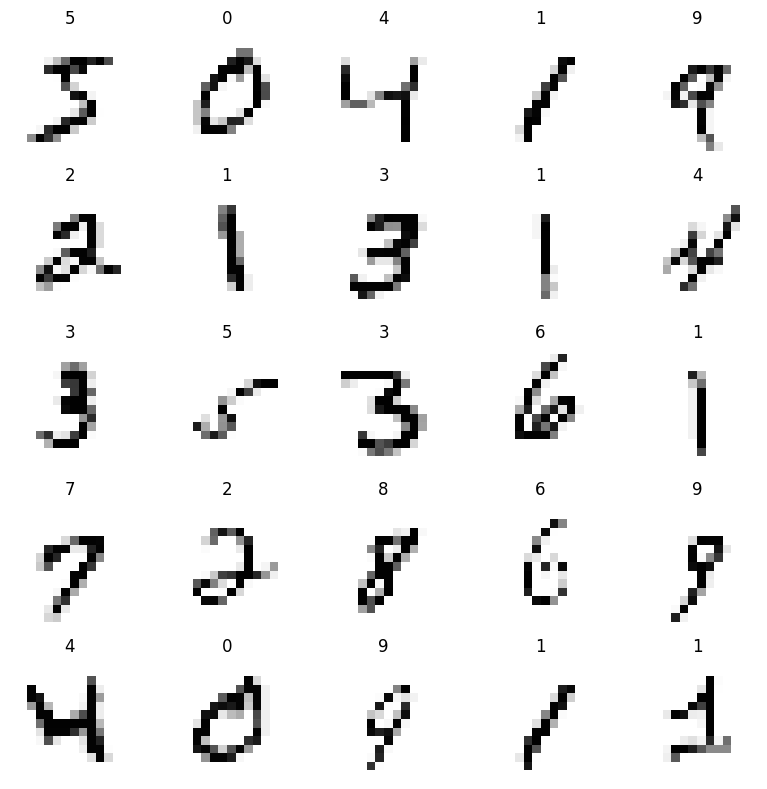

In [ ]:
plot_images(XtrnSR[:, :, :, 0], Ytrn, vmax=1)

^this is the half resolution


we don't need one hot encoding btw...


Initially, it was not working / was not plotting the resolution numbers. Then, Willow changed it.



we need ydata to be in original resolution;

we want model that takes image and double the resolution

# Build the CNN autoencoder

In [ ]:
#this is the meat


def build_cnn_autoencoder(input_shape):
  inputs = layers.Input(shape=input_shape)

  #The encoder
  x = layers.Conv2D(16, kernel_size=(3,3), padding = 'same', activation = 'relu')(inputs) #give previous layer
  x = layers.Conv2D(8, kernel_size=(3,3), padding='same', activation = 'relu')(x)
  x = layers.Conv2D(4, kernel_size=(3,3), padding='same', activation = 'relu')(x)
  x= layers.MaxPooling2D(pool_size=(2,2))(x) #this layer flattened

  shape = x.shape
  num_neurons = shape[1] * shape[2] *shape[3]

  #The Latent space
  x = layers.Flatten()(x)
  LS = layers.Dense(16, activation = "relu")(x)
  x = layers.Dense(num_neurons, activation = 'relu')(LS)
  x = layers.Reshape(shape[1:])(x)


  #The decoder
  x = layers.Conv2DTranspose(4, kernel_size=(3,3), padding = 'same', activation = 'relu')(x)
  x = layers.Conv2DTranspose(8, kernel_size=(3,3), padding='same', activation='relu')(x)
  x = layers.Conv2DTranspose(16, kernel_size=(3,3), padding = 'same', activation = 'relu')(x)

  x = layers.UpSampling2D(size=(2,2))(x)

  #more transposed Conv layers


  x = layers.Conv2DTranspose(16, kernel_size=(3,3), padding='same', activation = 'relu')(x)
  x = layers.Conv2DTranspose(16, kernel_size=(3,3), padding='same', activation = 'relu')(x)
  x = layers.Conv2DTranspose(16, kernel_size=(3,3), padding='same', activation = 'relu')(x)
  x = layers.UpSampling2D(size=(2,2))(x)
  x = layers.Conv2DTranspose(16, kernel_size=(3,3), padding='same', activation = 'sigmoid')(x)
  x = layers.Conv2DTranspose(16, kernel_size=(3,3), padding='same', activation = 'sigmoid')(x)
  outputs = layers.Conv2DTranspose(1, kernel_size=(3,3), padding = 'same', activation='sigmoid')(x)


  model = keras.Model(inputs, outputs)

  encoder = keras.Model(inputs, LS)
  decoder = keras.Model(LS, outputs)

  return model, encoder, decoder


input_shape = XtrnSR.shape[1:]
model, encoder, decoder = build_cnn_autoencoder(input_shape)
model.summary()





Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 14, 14, 1)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 8)         1160      
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 4)         292       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 7, 7, 4)           0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 196)               0         
                                                           

# Train the model (use a GPU)

^go to runtime, then change runtime type. then select GPU

In [ ]:
model.compile(loss='mse', optimizer='adam')

history = model.fit(XtrnSR, YtrnSR, batch_size = 256, epochs=15, validation_split=0.1)

Epoch 1/15
211/211 [==============================] - 18s 18ms/step - loss: 0.0803 - val_loss: 0.0570
Epoch 2/15
211/211 [==============================] - 3s 14ms/step - loss: 0.0462 - val_loss: 0.0386
Epoch 3/15
211/211 [==============================] - 3s 15ms/step - loss: 0.0331 - val_loss: 0.0284
Epoch 4/15
211/211 [==============================] - 3s 13ms/step - loss: 0.0269 - val_loss: 0.0252
Epoch 5/15
211/211 [==============================] - 3s 13ms/step - loss: 0.0245 - val_loss: 0.0233
Epoch 6/15
211/211 [==============================] - 3s 13ms/step - loss: 0.0230 - val_loss: 0.0220
Epoch 7/15
211/211 [==============================] - 3s 14ms/step - loss: 0.0218 - val_loss: 0.0210
Epoch 8/15
211/211 [==============================] - 3s 15ms/step - loss: 0.0208 - val_loss: 0.0202
Epoch 9/15
211/211 [==============================] - 3s 13ms/step - loss: 0.0201 - val_loss: 0.0200
Epoch 10/15
211/211 [==============================] - 3s 13ms/step - loss: 0.0194 - val_l

# Visualize loss curve

In [ ]:
#loss should be going down

# Visualize the predictions

In [ ]:
PtstSR = model.predict(XtstSR)
PtstSR.shape

313/313 [==============================] - 1s 3ms/step


(10000, 28, 28, 1)

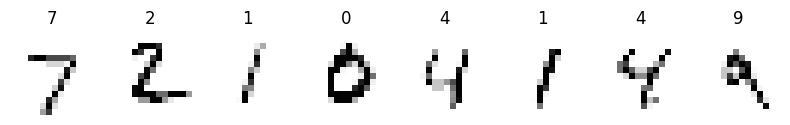

In [ ]:
plot_images(XtstSR[..., 0], Ytst, nrows=1, ncols = 8, vmax=1)

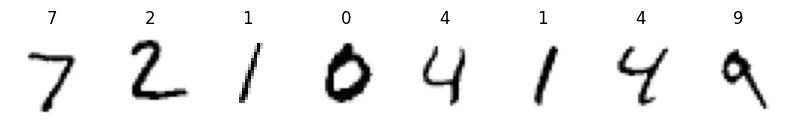

In [ ]:
plot_images(YtstSR[..., 0], Ytst, nrows = 1, ncols = 8, vmax = 1)

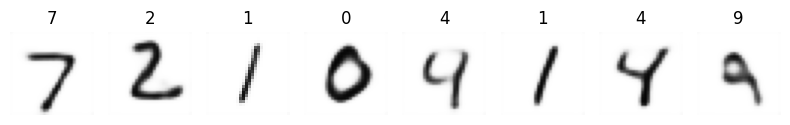

In [ ]:
plot_images(PtstSR[..., 0], Ytst, nrows = 1, ncols = 8, vmax = 1)

we've build super=resolution autoencoder

# Visualize the early layers

In [ ]:
model.layers[1].get_weights()[0].shape

(3, 3, 1, 16)

3 by 3 here

we had 16 filters. that's the 16 here.


# Visualize the latent space with the encoder and decoder on their own

In [ ]:
#just the encoder and the decoder

#Willow shows, check class recording


#also input something to decode and see what happens

# Find the average latent space representation for each digit

# Decode latent space representations with the decoder

# What if we input something in the latent space by hand and then decode it?